<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/main/arima_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
df=pd.read_csv('https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20June%2010%20sec%20data.csv')
df=df[['Date & Time','Active Power kW']]
df=df.head(1000)

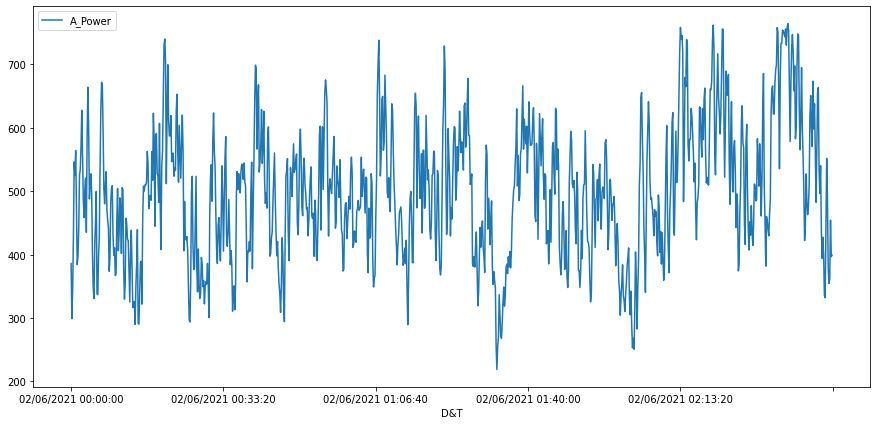

In [47]:
# Updating the header
df.columns=["D&T","A_Power"]
df.describe()
df.set_index('D&T',inplace=True)

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
df.plot()

In [48]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['A_Power'])

In [49]:
def adfuller_test(A_Power):
    result=adfuller(A_Power)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['A_Power'])

ADF Test Statistic : -5.844328223338885
p-value : 3.714045002188618e-07
#Lags Used : 7
Number of Observations : 992
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [50]:
'''df['A_power First Difference'] = df['A_Power'] - df['A_Power'].shift(2)
df.head()'''

"df['A_power First Difference'] = df['A_Power'] - df['A_Power'].shift(2)\ndf.head()"

In [51]:
# Again testing if data is stationary
#dfuller_test(df['A_power First Difference'].dropna())

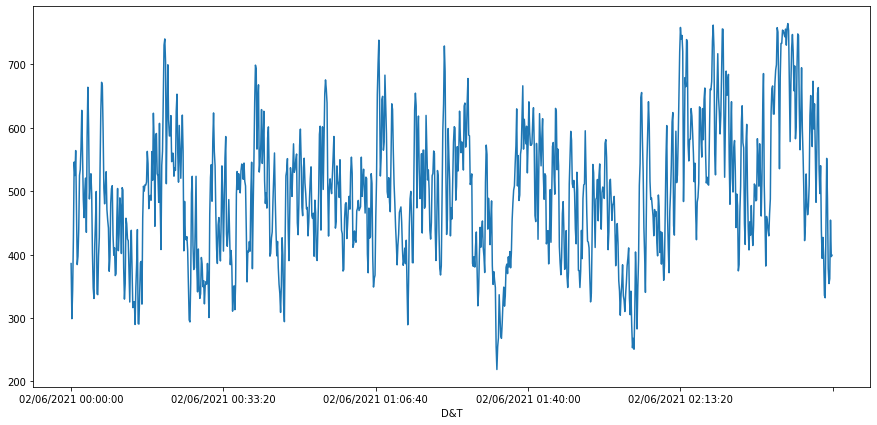

In [52]:
df['A_Power'].plot()

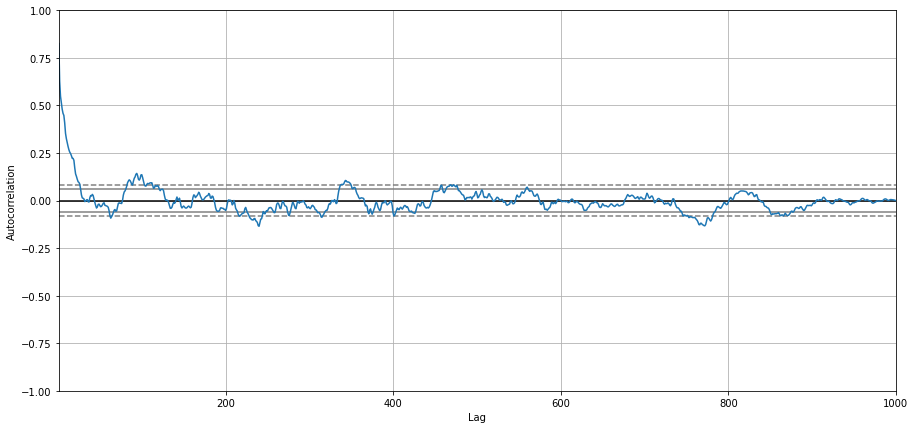

In [53]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['A_Power'])
plt.show()

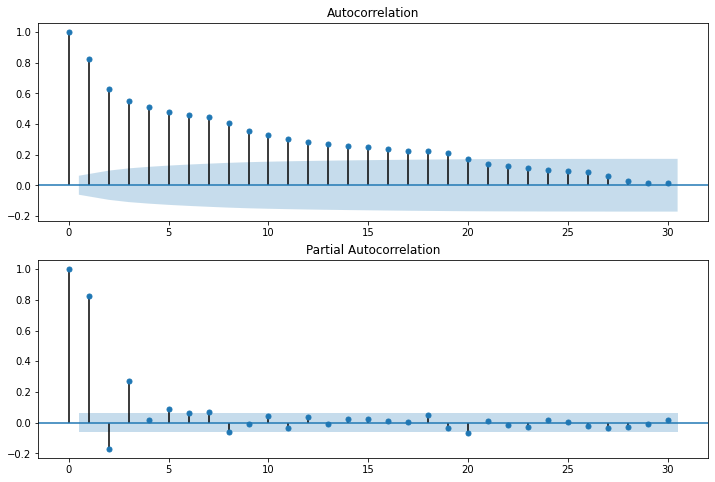

In [54]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['A_Power'].dropna(),lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['A_Power'].dropna(),lags=30,ax=ax2)

In [60]:
# For non-seasonal data
#p=1, d=2, q= 1

from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df['A_Power'],order=(1,0,2))
model_fit=model.fit()
print(model_fit.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                A_Power   No. Observations:                 1000
Model:                     ARMA(1, 2)   Log Likelihood               -5452.837
Method:                       css-mle   S.D. of innovations             56.440
Date:                Sat, 21 Aug 2021   AIC                          10915.674
Time:                        15:20:39   BIC                          10940.212
Sample:                    02-06-2021   HQIC                         10925.000
                         - 02-06-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           496.3368     13.175     37.671      0.000     470.513     522.160
ar.L1.A_Power     0.9031      0.023     40.073      0.000       0.859       0.947
ma.L1.A_Power     0.0580      0.045     

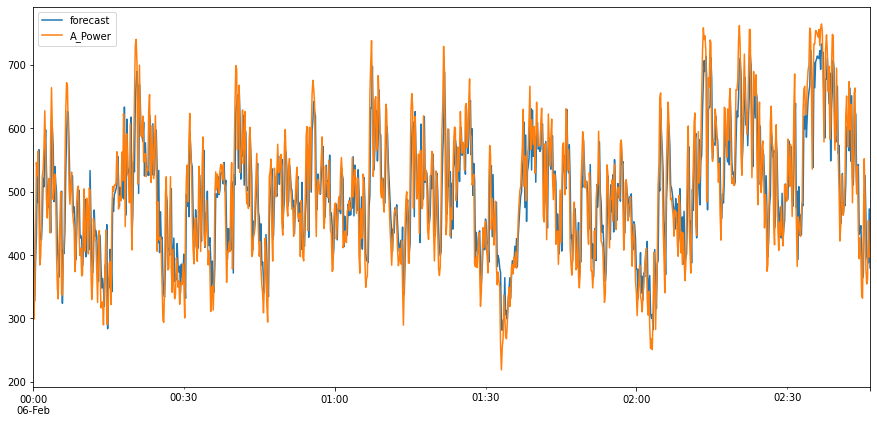

In [61]:
#df['forecast']=model_fit.predict(dynamic=True)
#df[['A_Power','forecast']].plot(figsize=(12,8))
model_fit.plot_predict(dynamic=False)
plt.show()

In [78]:

from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df['A_Power'][:850]
test = df['A_Power'][850:]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)


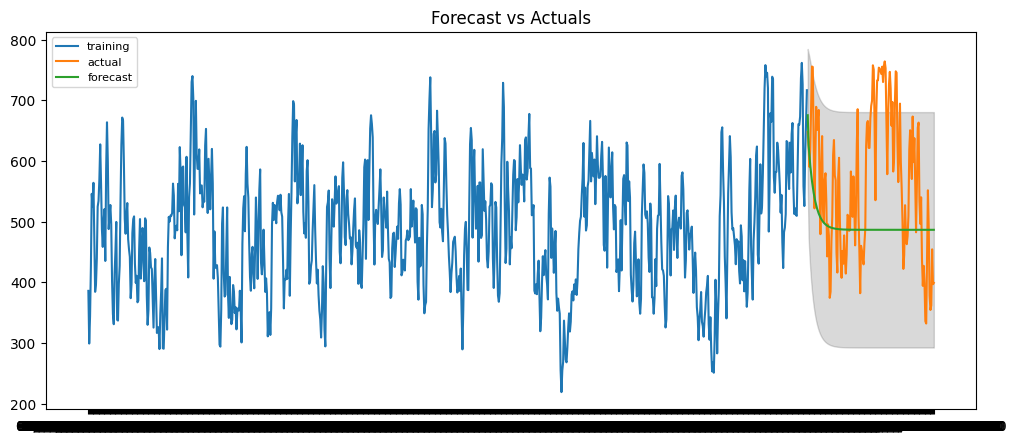

In [67]:
# Build Model 
model = ARIMA(train, order=(1, 0, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(150, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [64]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

#> {'mape': 0.02250131357314834,
#>  'me': 3.230783108990054,
#>  'mae': 4.548322194530069,
#>  'mpe': 0.016421001932706705,
#>  'rmse': 6.373238534601827,
#>  'acf1': 0.5105506325288692,
#>  'corr': 0.9674576513924394,
#>  'minmax': 0.02163154777672227}

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'acf1': 0.8155092388329994,
 'corr': 0.18123232894852961,
 'mae': 106.38646749992944,
 'mape': 0.17639378414611595,
 'me': -71.544617524479,
 'minmax': 0.16854753009499457,
 'mpe': -0.08959200345718157,
 'rmse': 133.44992821066384}